## The project's objective is to create an image classification model for Amsterdam neighborhoods identification.

#### It is based on Garbage In, Garbage Out dataset, which was primarily collected for urban garbage classification. Thanks to coordinates in the metadata file, I was able to use this dataset for another, much more interesting topic for me. To create a link between images and the neighborhoods they were taken in, I’ve used geodata from the Amsterdam municipality website.


In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from shapely.geometry import mapping

import os
import shutil
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import re
import matplotlib.pyplot as plt
from PIL import Image
from natsort import natsorted  
from tqdm import tqdm  

In [2]:
file_path_metadata = '/ai_project/to_read/metadata.csv'
metadata = pd.read_csv(file_path_metadata)

flie_path_neighborhoods = '/ai_project/to_read/INDELING_GEBIED.csv'
neighborhoods = gpd.read_file(flie_path_neighborhoods)

### Combine image metadata with dataset containing polygons representing Amsterdam neighborhoods' boundaries

In [3]:
neighborhoods['geometry'] = neighborhoods['WKT_LNG_LAT'].apply(wkt.loads)
neighborhoods_gdf = gpd.GeoDataFrame(neighborhoods, geometry='geometry')
neighborhoods_gdf.set_crs("EPSG:4326", inplace=True)

metadata_gdf = gpd.GeoDataFrame(
    metadata, 
    geometry=gpd.points_from_xy(metadata['lng'], metadata['lat']),
    crs="EPSG:4326"  # WGS84 Coordinate Reference System
)

metadata_with_neighborhoods = gpd.sjoin(metadata_gdf, neighborhoods_gdf, how='left', predicate='within')

In [4]:
neighborhoods_gdf['geometry_coordinates'] = neighborhoods_gdf['geometry'].apply(lambda x: mapping(x)['coordinates'])

unique_neighborhoods = neighborhoods_gdf['Gebied'].unique()
colors = px.colors.qualitative.Set3 
color_map = {neighborhood: colors[i % len(colors)] for i, neighborhood in enumerate(unique_neighborhoods)}

fig = go.Figure()

for _, row in neighborhoods_gdf.iterrows():
    coordinates = row['geometry_coordinates'][0]  
    lons, lats = zip(*coordinates)
    fig.add_trace(go.Scattermapbox(
        lon=lons,
        lat=lats,
        fill='toself',
        fillcolor=color_map[row['Gebied']],
        line=dict(color='black'),
        mode='lines',
        name=row['Gebied']  
    ))

fig.add_trace(go.Scattermapbox(
    lon=metadata_with_neighborhoods['lng'],
    lat=metadata_with_neighborhoods['lat'],
    mode='markers',
    marker=dict(size=5, color='black'),
    name='Images'
))

fig.update_layout(
    title="Images and Neighborhoods in Amsterdam",
    mapbox=dict(
        style="carto-positron",
        center=dict(lat=52.35341, lon=4.875487), 
        zoom=9  
    ),
    legend=dict(yanchor="top", y=1, xanchor="left", x=0.01),
    margin=dict(l=0, r=0, t=50, b=0)
)

fig.show()

The figure of Images and Neighborhoods in Amsterdam is not loading, as an interactive package was applied for presentation purposes. If needed, figures can be delivered.

#### Clean the dataset from location outliers and heavily underrepresented regions (< 750 occurances)

In [5]:
# Delete location outliers
condition_1 = metadata_with_neighborhoods['lng'] > 5.4
condition_2 = (metadata_with_neighborhoods['lat'] > 52.36) & (metadata_with_neighborhoods['lng'] > 5)
gebied_counts = metadata_with_neighborhoods['Gebied'].value_counts()
# Identify neighborhoods with counts less than 750
condition_3 = metadata_with_neighborhoods['Gebied'].isin(gebied_counts[gebied_counts < 750].index)

deleted_neighborhoods = metadata_with_neighborhoods.loc[condition_3, 'Gebied'].unique()
print("Neighborhoods deleted under condition 3:", deleted_neighborhoods)

invalid_condition = condition_1 | condition_2 | condition_3
non_fulfilled = metadata_with_neighborhoods[invalid_condition]
non_fulfilled_filenames = non_fulfilled['filename']
metadata_with_neighborhoods = metadata_with_neighborhoods[~invalid_condition]

Neighborhoods deleted under condition 3: ['De Pijp, Rivierenbuurt' 'Centrum-Oost' 'Oud-West, De Baarsjes'
 'Bijlmer-Centrum' 'Indische Buurt, Oostelijk Havengebied' 'Osdorp'
 'Sloterdijk Nieuw-West' 'Westerpark' 'Centrum-West'
 'Geuzenveld, Slotermeer' 'Oud-Oost' 'Oud-Noord' 'Buitenveldert, Zuidas']


In [6]:
folder_path = "/Users/epeda/Downloads/images_original"
filenames_series = non_fulfilled_filenames

deleted_files = []
not_found_files = []
    
for filename in filenames_series:
    file_path = os.path.join(folder_path, filename)
    if os.path.exists(file_path):
        os.remove(file_path)
        deleted_files.append(filename)
    else:
        not_found_files.append(filename)

print(f"Deleted {len(deleted_files)} files.")
if not_found_files:
    print(f"Warning: {len(not_found_files)} files were not found in the folder.")


labels = metadata_with_neighborhoods[['filename', 'Gebied']]
labels['photo_id'] = labels['filename'].str.extract('(\d+)').astype(int) 
labels = labels.sort_values(by='photo_id').drop(columns=['photo_id'])

<>:24: SyntaxWarning:

invalid escape sequence '\d'

<>:24: SyntaxWarning:

invalid escape sequence '\d'

/var/folders/vd/hvjkn6r967gbp6srtfrlgnz40000gn/T/ipykernel_9314/2795830522.py:24: SyntaxWarning:

invalid escape sequence '\d'



Deleted 3845 files.


/var/folders/vd/hvjkn6r967gbp6srtfrlgnz40000gn/T/ipykernel_9314/2795830522.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [7]:
neighborhoods_gdf['geometry_coordinates'] = neighborhoods_gdf['geometry'].apply(lambda x: mapping(x)['coordinates'])

unique_neighborhoods = neighborhoods_gdf['Gebied'].unique()
colors = px.colors.qualitative.Set3
color_map = {neighborhood: colors[i % len(colors)] for i, neighborhood in enumerate(unique_neighborhoods)}

fig = go.Figure()

for _, row in neighborhoods_gdf.iterrows():
    coordinates = row['geometry_coordinates'][0] 
    lons, lats = zip(*coordinates)
    fig.add_trace(go.Scattermapbox(
        lon=lons,
        lat=lats,
        fill='toself',
        fillcolor=color_map[row['Gebied']], 
        line=dict(color='black'),
        mode='lines',
        name=row['Gebied'] 
    ))

fig.add_trace(go.Scattermapbox(
    lon=metadata_with_neighborhoods['lng'],
    lat=metadata_with_neighborhoods['lat'],
    mode='markers',
    marker=dict(size=5, color='black'),
    name='Images'
))

fig.update_layout(
    title="Images and Neighborhoods in Amsterdam",
    mapbox=dict(
        style="carto-positron", 
        center=dict(lat=52.35341, lon=4.875487),  
        zoom=10 
    ),
    legend=dict(yanchor="top", y=1, xanchor="left", x=0.01),
    margin=dict(l=0, r=0, t=50, b=0)
)

fig.show()

In [8]:
labels_count = labels.groupby('Gebied').size().reset_index(name='photo_count')

## Undersampling (Reducing Data from Overrepresented Regions) 

#### For this purpose, a duplicate folder of the images needs to be created 

In [9]:
source_folder = "/Users/epeda/Downloads/images_original"
new_folder = "/Users/epeda/Downloads/images_reduced_augmented"

if os.path.exists(source_folder) and not os.path.exists(new_folder):
    shutil.copytree(source_folder, new_folder)
    print(f"Folder '{source_folder}' successfully duplicated to '{new_folder}'.")
else:
    print("Error: Source folder does not exist or destination folder already exists.")


Folder '/Users/epeda/Downloads/images_original' successfully duplicated to '/Users/epeda/Downloads/images_reduced_augmented'.


In [10]:
image_folder = '/Users/epeda/Downloads/images_reduced_augmented'

neighborhood_counts = labels.groupby('Gebied').size().reset_index(name='photo_count')
overrepresented_neighborhoods = neighborhood_counts[neighborhood_counts['photo_count'] > 2000]['Gebied'].tolist()
labels_reduced = labels

def reduce_images_for_neighborhood(neighborhood, target_count=2000):
    global labels_reduced 

    neighborhood_images = labels_reduced[labels_reduced['Gebied'] == neighborhood]['filename'].tolist()
    num_to_delete = len(neighborhood_images) - target_count
    images_to_delete = np.random.choice(neighborhood_images, size=num_to_delete, replace=False)

    for img in images_to_delete:
        img_path = os.path.join(image_folder, img)
        if os.path.exists(img_path):
            os.remove(img_path)

    labels_reduced = labels_reduced[~labels_reduced['filename'].isin(images_to_delete)]

for neighborhood in overrepresented_neighborhoods:
    reduce_images_for_neighborhood(neighborhood)

## Oversampling (Data Augmentation)

In [11]:
neighborhood_counts = labels_reduced.groupby('Gebied').size().reset_index(name='photo_count')

threshold = 1500
underrepresented_neighborhoods = neighborhood_counts[neighborhood_counts['photo_count'] < threshold]['Gebied'].tolist()

datagen = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest'
)

augmented_metadata = []

def augment_images_from_neighborhood(neighborhood, num_augmentations=150):

    neighborhood_images = labels_reduced[labels_reduced['Gebied'] == neighborhood]['filename'].tolist()
    selected_images = np.random.choice(neighborhood_images, size=min(num_augmentations, len(neighborhood_images)), replace=False)

    for file_name in selected_images:
        img_path = os.path.join(image_folder, file_name)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Error reading {img_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.expand_dims(img, 0)

        aug_iter = datagen.flow(img, batch_size=1)

        for i in range(5):  
            aug_img = next(aug_iter)[0].astype('uint8')

            base_name = os.path.splitext(file_name)[0]
            new_filename = f"{base_name}_augmented_{i}.jpg"
            new_img_path = os.path.join(image_folder, new_filename)

            cv2.imwrite(new_img_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))

            original_metadata = labels_reduced[labels_reduced['filename'] == file_name].iloc[0].copy()
            original_metadata['filename'] = new_filename
            augmented_metadata.append(original_metadata)

for neighborhood in underrepresented_neighborhoods:
    augment_images_from_neighborhood(neighborhood)

new_metadata_df = pd.DataFrame(augmented_metadata)
labels_reduced_augmented = pd.concat([labels_reduced, new_metadata_df], ignore_index=True)

print("Augmentation and metadata update completed!")

Augmentation and metadata update completed!


In [12]:
def sort_key(filename):
    match = re.match(r"(\d+)(_augmented_(\d+))?", filename)
    if match:
        base_number = int(match.group(1)) 
        augmented_index = int(match.group(3)) if match.group(3) else -1  
        return (base_number, augmented_index)
    return (float('inf'), float('inf')) 

labels_reduced_augmented = labels_reduced_augmented.sort_values(by='filename', key=lambda x: x.apply(sort_key))

In [13]:
labels_reduced_augmented_count = labels_reduced_augmented.groupby('Gebied').size().reset_index(name='photo_count')

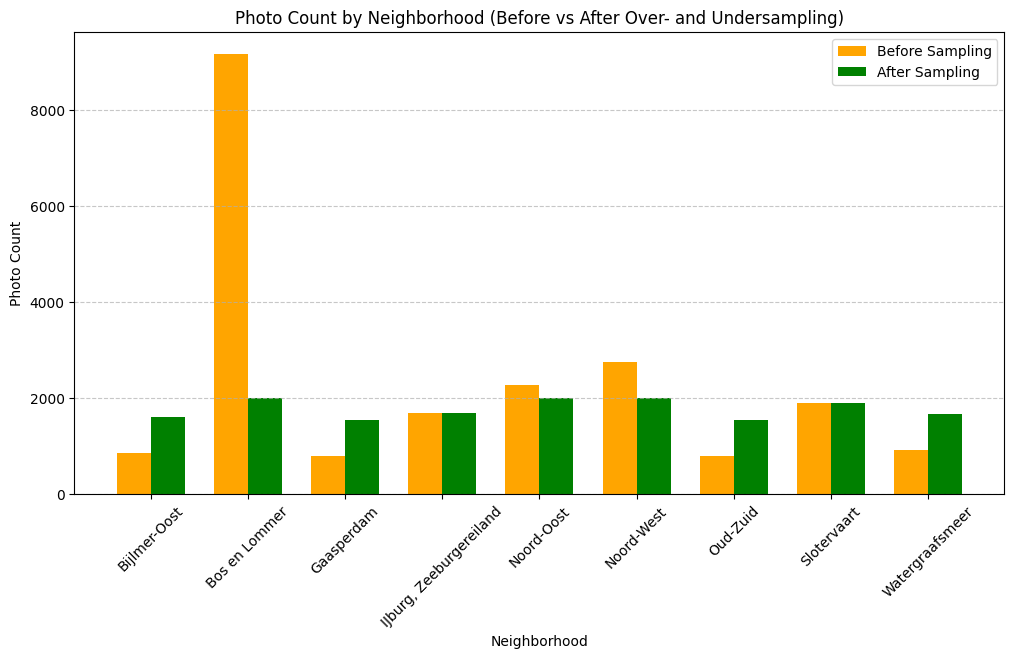

In [14]:
bar_width = 0.35
bar_color_before = 'orange'
bar_color_after = 'green'

x = np.arange(len(labels_count['Gebied']))

plt.figure(figsize=(12, 6))

plt.bar(x - bar_width/2, labels_count['photo_count'], width=bar_width, color=bar_color_before, label='Before Sampling')

plt.bar(x + bar_width/2, labels_reduced_augmented_count['photo_count'], width=bar_width, color=bar_color_after, label='After Sampling')

plt.xlabel('Neighborhood')
plt.ylabel('Photo Count')
plt.title('Photo Count by Neighborhood (Before vs After Over- and Undersampling)')
plt.xticks(ticks=x, labels=labels_count['Gebied'], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


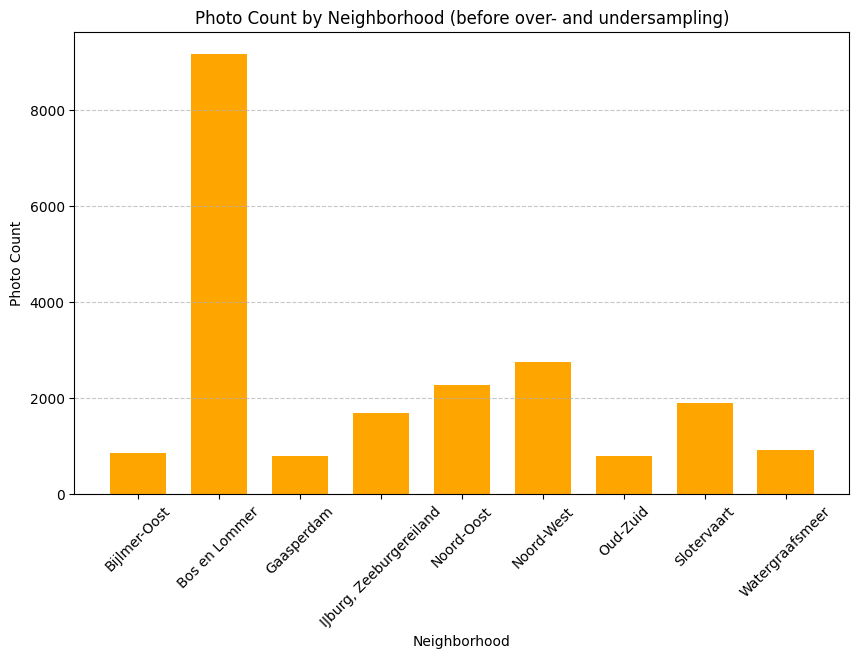

In [15]:
bar_width = 0.7
bar_color = 'orange'

plt.figure(figsize=(10, 6))
plt.bar(labels_count['Gebied'], labels_count['photo_count'], width=bar_width, color=bar_color)
plt.xlabel('Neighborhood')
plt.ylabel('Photo Count')
plt.title('Photo Count by Neighborhood (before over- and undersampling)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

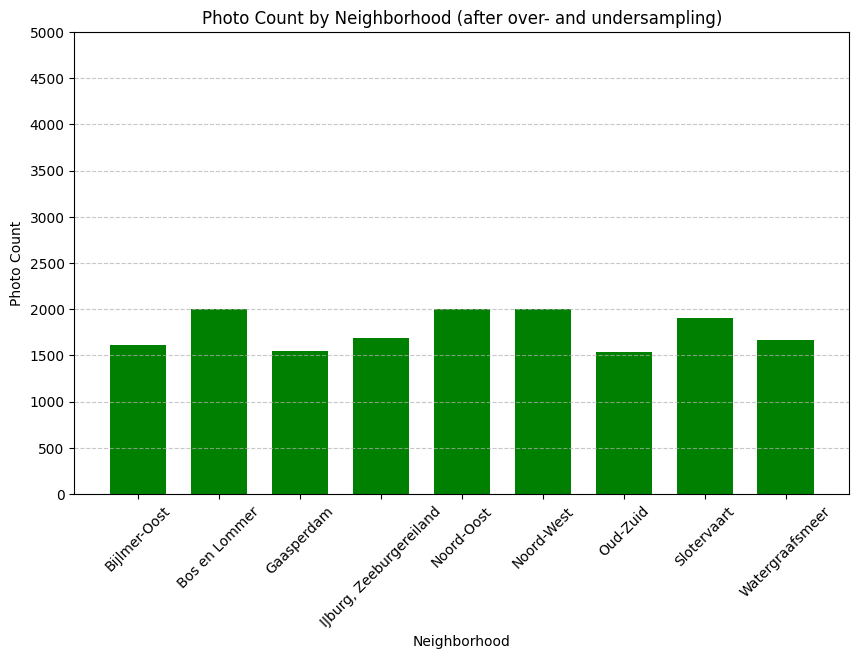

In [16]:
bar_width = 0.7
bar_color = 'green'

plt.figure(figsize=(10, 6))
plt.bar(labels_reduced_augmented_count['Gebied'], labels_reduced_augmented_count['photo_count'], width=bar_width, color=bar_color)
plt.xlabel('Neighborhood')
plt.ylabel('Photo Count')
plt.title('Photo Count by Neighborhood (after over- and undersampling)')
plt.xticks(rotation=45)
plt.yticks(range(0, 5001, 500))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

### Save the labels after over- and undersampling and original labels

In [17]:
np.save('labels_reduced_augmented', labels_reduced_augmented)

In [18]:
np.save('labels_original', labels)

## Save datasets as numpy arrays

In [19]:
input_folder = "/Users/epeda/Downloads/images_reduced_augmented"
output_resolution = (224, 224)

dataset_reduced_augmented = []

filenames = natsorted(f for f in os.listdir(input_folder) if f.endswith(".jpg"))

for filename in tqdm(filenames, desc="Processing images", unit="image"):
    file_path = os.path.join(input_folder, filename)
    
    with Image.open(file_path) as img:

        resized_img = img.resize(output_resolution)
        image_array = np.array(resized_img)
        dataset_reduced_augmented.append(image_array)

dataset_reduced_augmented = np.array(dataset_reduced_augmented)

print(f"Dataset (reduced and augmented) shape: {dataset_reduced_augmented.shape}")


Processing images: 100%|██████████| 15954/15954 [02:28<00:00, 107.63image/s]


Dataset (reduced and augmented) shape: (15954, 224, 224, 3)


In [20]:
input_folder = "/Users/epeda/Downloads/images_original"
output_resolution = (224, 224)

dataset_original = []

filenames = natsorted(f for f in os.listdir(input_folder) if f.endswith(".jpg"))

for filename in tqdm(filenames, desc="Processing images", unit="image"):
    file_path = os.path.join(input_folder, filename)
    
    with Image.open(file_path) as img:

        resized_img = img.resize(output_resolution)
        image_array = np.array(resized_img)
        dataset_original.append(image_array)

dataset_original = np.array(dataset_original)

print(f"Dataset (original) shape: {dataset_original.shape}")

Processing images: 100%|██████████| 21155/21155 [02:59<00:00, 117.97image/s]


Dataset (original) shape: (21155, 224, 224, 3)


In [22]:
np.save("dataset_reduced_and_augemented.npy", dataset_reduced_augmented)

In [23]:
np.save("dataset_original.npy", dataset_original)